In [161]:
# External libraries
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
import requests

a_size = (16, 11)
a2_size = (16, 5.5)
sns.set()

In [162]:
import os

from zipfile import ZipFile
from io import BytesIO

from typing import List

In [163]:
def make_confidence(mean, variance, factor = 1.64):
    N = len(mean)
    
    half_int = factor*np.sqrt(variance)
    
    confidence_intervals = np.zeros((N, 2))
    confidence_intervals[:, 0] = mean - half_int
    confidence_intervals[:, 1] = mean + half_int
        
    return confidence_intervals

In [231]:
def plot_quadrant(data, xs, datapoints = None, titles = [], ci = True, only_first = False):
    filtered_state, variance = data[:, 0], data[:, 1]
    
    errors, prediction_variance = data[:, 2], data[:, 3]
    
    if only_first:
        rows = 1
        size = a2_size
    else:
        rows = 2      
        size = a_size
    
    fig, axis = plt.subplots(rows, 2, figsize = size)
    
    if not only_first:
        ((ax1, ax2), (ax3, ax4)) = axis
    else:
        (ax1, ax2) = axis

    if datapoints is not None:
        ax1.scatter(xs, datapoints)
    
    titles += [''] * (4 - len(titles))
    t1, t2, t3, t4 = titles
    
    ax1.set_title(t1)
    ax1.plot(xs, filtered_state)
    
    if ci: 
        confidence_intervals = make_confidence(filtered_state, variance)  
        ax1.plot(xs, confidence_intervals[:, 0], '--')
        ax1.plot(xs, confidence_intervals[:, 1], '--')
    
    ax2.set_title(t2)
    ax2.plot(xs, variance)
    
    if not only_first:
        ax3.set_title(t3)
        ax3.plot(xs, errors)
        ax3.axhline(0, alpha=0.4)

        ax4.set_title(t4)
        ax4.plot(xs, prediction_variance)
    
    plt.show()

## Assignment - Part 2

In [232]:
def read_dat(dat_string: List[str]) -> np.array:
    data = []
    for line in dat_string:
        invalid = len(line) < 1 or '//' in line
        if invalid: continue
        
        datum_str = line.replace('\n', '')
        data.append(np.float(datum_str))
        
    return np.array(data)
        

In [233]:
def get_data(path='', remote_url = 'http://www.ssfpack.com/files/DK-data.zip'):
    filepath = os.path.join(path, "Nile.dat")
    
    if os.path.isfile(filepath):
        with open(filepath, 'r') as file:
            out = file.readlines()
        return read_dat(out)
            
    else:
        r = requests.get(remote_url, stream=True)
        with ZipFile(BytesIO(r.content)) as zipped_data:
            with zipped_data.open('Nile.dat') as nile:
                out = [line.decode("utf-8") for line in nile.readlines()]
        
        return read_dat(out)

In [234]:
data = get_data('data')
base_year = 1871
end_year = base_year+len(data)

### Local level Kalman Filter

In [235]:
def neg_log_likelihood(filtered):
    
    v, F = filtered[:, 2], filtered[:, 3]

    mean = np.sum(np.abs(F))
    var = np.sum(np.square(v)/F)
    L = 0.5*(mean+var)
    
    return L

In [236]:
 def KF_step(var_eps, var_eta):
        def step(y, a, P, prev_v, prev_F):
            missing = np.isnan(y)
            v = y - a if not missing else 1
            F = P + var_eps if not missing else np.inf
            
            K = P / F

            a_prime = a + K*v
            P_prime = P*(1-K) + var_eta
        

            return a_prime, P_prime, v, F
        return step
    
def KF(series, a_init, P_init, var_eps, var_eta):
    
    T = len(series)
    filtered = np.zeros((T+1, 4))

    filtered[0] = [a_init, P_init, None, None]
    step = KF_step(var_eps, var_eta)
    
    for t, y in enumerate(series):
        a_prime, P_prime, v, F = step(y, *filtered[t])
        filtered[t, 2:] = [v, F]
        filtered[t+1, :2] = [a_prime, P_prime]
        

    return filtered[1:-1]

In [237]:
positive_bounds = ((0, None), (0, None))
def max_likelihood_KF(series, a_init, P_init, var_eps=None, var_eta=None, verbose=False):
    
    if var_eps is None or var_eta is None:
        if verbose: print("Estimating with Maximum Likelihood...")
        res = opt.minimize(
            lambda params: neg_log_likelihood(
                KF(series, a_init, P_init, *params)
            ),
            [10_000, 1_000], bounds=positive_bounds
        )
        var_eps, var_eta = res.x
        
        if not res.success:
            #raise ValueError(f'Var_eps={var_eps}, Var_eta={var_eta}\n{res.message}')
            print("error", res.message)
            
        if verbose:
            print(f"Var_eps={var_eps}, Var_eta={var_eta}")

    return KF(series, a_init, P_init, var_eps, var_eta), var_eps, var_eta

### Figure 2.1

In [238]:
params = { 'var_eps': 15_099., 'var_eta': 1_469.1 } 
init = { 'a_init': 0, 'P_init': 10e7 }

In [239]:
filtered, var_eps, var_eta = max_likelihood_KF(data, **init, **params, verbose=True)

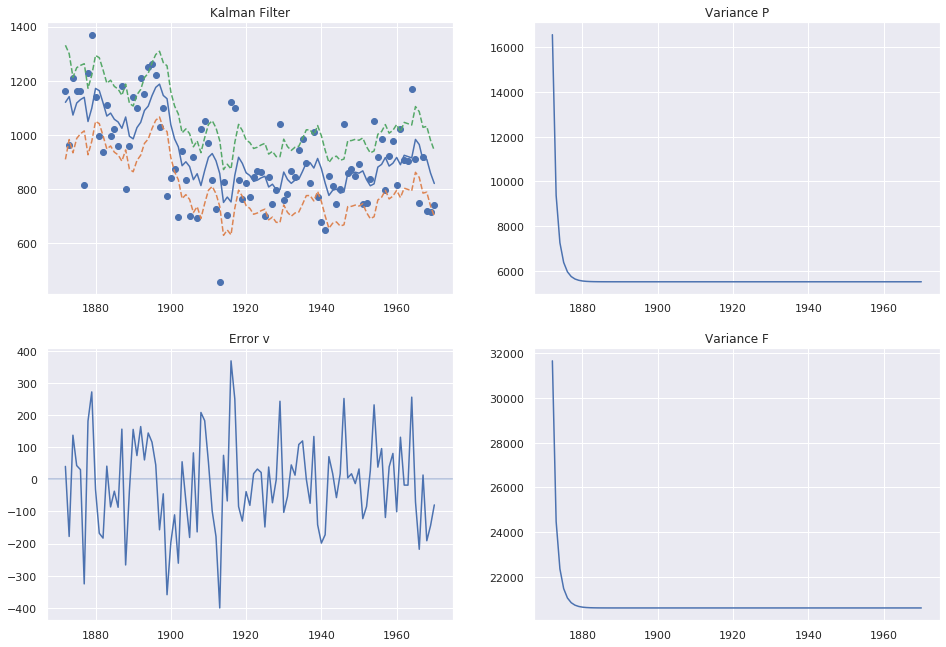

In [240]:
x_axis = range(base_year+1, end_year)
plot_quadrant(filtered, x_axis,
              datapoints=data[1:],
              titles=["Kalman Filter", "Variance P", "Error v", "Variance F"])

### State Smoothing

In [241]:
def cumulative_smoothings(v, F, P):
    n = len(v)
    L = 1 - P/F
    r = np.zeros(n + 1)
    N = np.zeros(n + 1)

    
    for t in reversed(range(1, n)):
        
        r[t] = v[t]/F[t] + L[t] * r[t + 1]
        N[t] = 1/F[t] + np.square(L[t]) * N[t + 1]
        
    return r[:-1], N[:-1]

def KF_smoothing(series, *kf_args, **kf_kwargs):
    
    filtered, var_eps, var_eta = max_likelihood_KF(series, *kf_args, **kf_kwargs)
    v, F = filtered[:, 2], filtered[:, 3]
    a, P = filtered[:, 0], filtered[:, 1]

    r, N = cumulative_smoothings(v, F, P)
        
    smoothed_state = a + P*r
    smoothed_var = P - np.square(P) * N
    
    smoothed = np.column_stack([smoothed_state, smoothed_var, r, N]) 
    
    return smoothed

### Figure 2.2

In [242]:
smoothed = KF_smoothing(data, **init, **params)

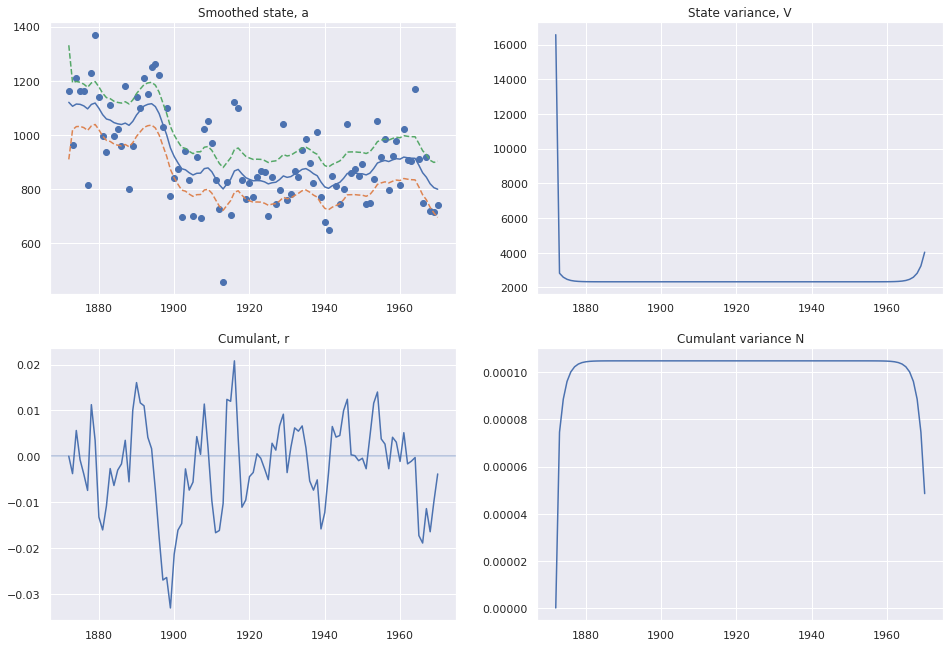

In [243]:
ts = ["Smoothed state, a", "State variance, V", "Cumulant, r", "Cumulant variance N"]
plot_quadrant(smoothed, x_axis,
              datapoints=data[1:], ci=True,
              titles=ts)

### Figure 2.3

In [244]:
def observation_disturbance(series, *kf_args, **kf_kwargs):
    filtered, var_eps, var_eta = max_likelihood_KF(series, *kf_args, **kf_kwargs)
    v, F = filtered[:, 2], filtered[:, 3]
    a, P = filtered[:, 0], filtered[:, 1]
    
    r, N = cumulative_smoothings(v, F, var_eps)
    
    K = P/F
    eps = var_eps*(v/F - r*K)
    D = 1/F + np.square(K)*N
    V_eps = var_eps - np.square(var_eps)*D
    
    eta = var_eta*r
    V_eta = var_eta - np.square(var_eta) * N
    
    return np.column_stack([eps, V_eps, eta, V_eta]) 

In [245]:
disturbance = observation_disturbance(data, **init, **params)

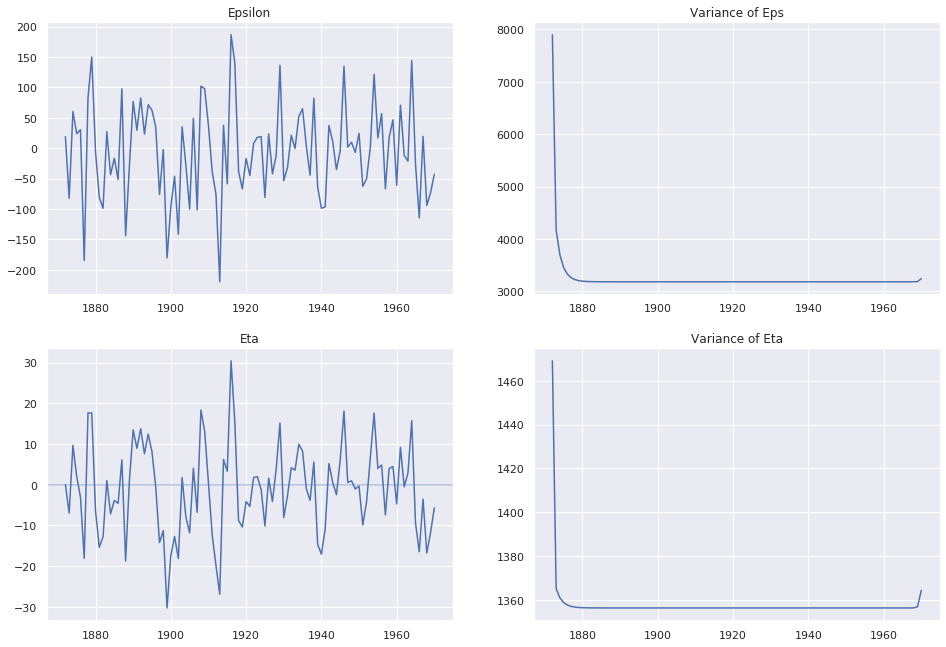

In [246]:
ts = ["Epsilon", "Variance of Eps", "Eta", "Variance of Eta"]
plot_quadrant(disturbance, x_axis, ci=False,
              titles=ts)

### Figure 2.5

In [247]:
missing_series = data.copy()
missing_series[21: 41] = np.nan
missing_series[61: 81] = np.nan

In [248]:
interp, _, _ = max_likelihood_KF(missing_series, **init, **params, verbose=True)

In [249]:
smoothed = KF_smoothing(missing_series, **init, **params)

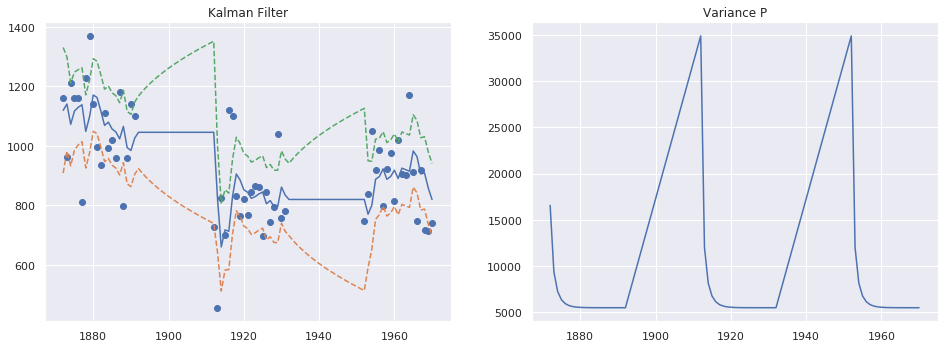

In [250]:
plot_quadrant(interp, x_axis,
              datapoints=missing_series[1:],
              ci=True,
              only_first=True,
              titles=["Kalman Filter", "Variance P"])

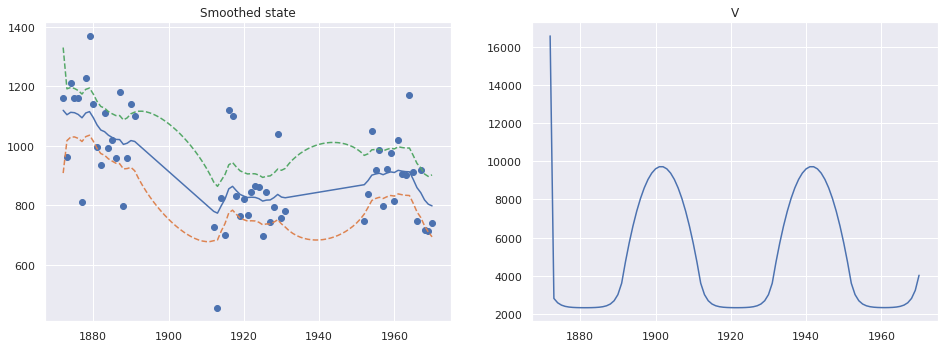

In [251]:
plot_quadrant(smoothed, x_axis,
              datapoints=missing_series[1:],
              ci=True,
              only_first=True,
              titles=["Smoothed state", "V"])

### Figure 2.6

In [263]:
forward = np.nan*np.ones(30)
forecast_data = np.append(data, forward)
interp_axis = range(base_year + 1, base_year + len(forecast_data))

In [264]:
extrap, _, _ = max_likelihood_KF(forecast_data, **init, **params, verbose=True)

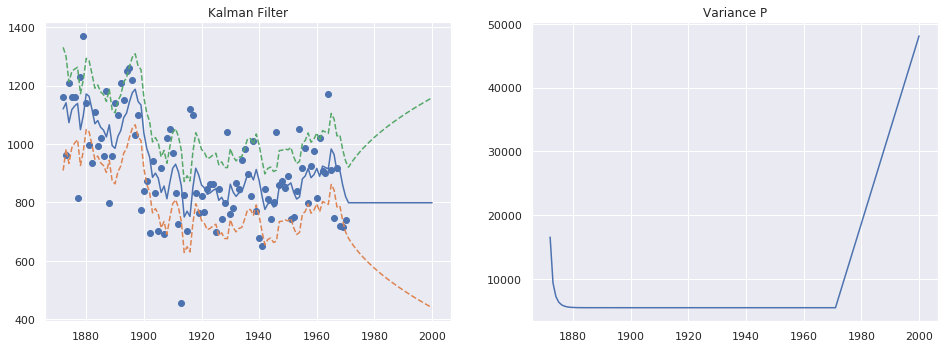

In [268]:
plot_quadrant(extrap, interp_axis,
              datapoints=forecast_data[1:],
              ci=True,
              only_first=True,
              titles=["Kalman Filter", "Variance P"])